# Coreloss Example
In this notebook, a typical workflow of EELS processing is shown on simulated data. This notebook shows one example of how core-loss quantification could be performed on a STEM-EELS dataset.

In [4]:
# %matplotlib qt 
#important for the em.MultiSpectrumVisualizer since this is an interactive plotting tool

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pyEELSMODEL.api as em

## STEM-EELS Simulation
A STEM-EELS map is simulated which will be used to quantify the spectra. For more information on how the simulation works one could check the *CoreLossExampleExtended* notebook.

In [6]:
from pyEELSMODEL.misc.data_simulator import simulate_data,plot_ground_truth

In [7]:
hl, ll, maps = simulate_data()

1024it [00:00, 1183.63it/s]


hll
hll
hll
hll
hll
hll


1024it [00:01, 731.18it/s]
1024it [00:00, 21639.19it/s]

Multispectrum is simulated


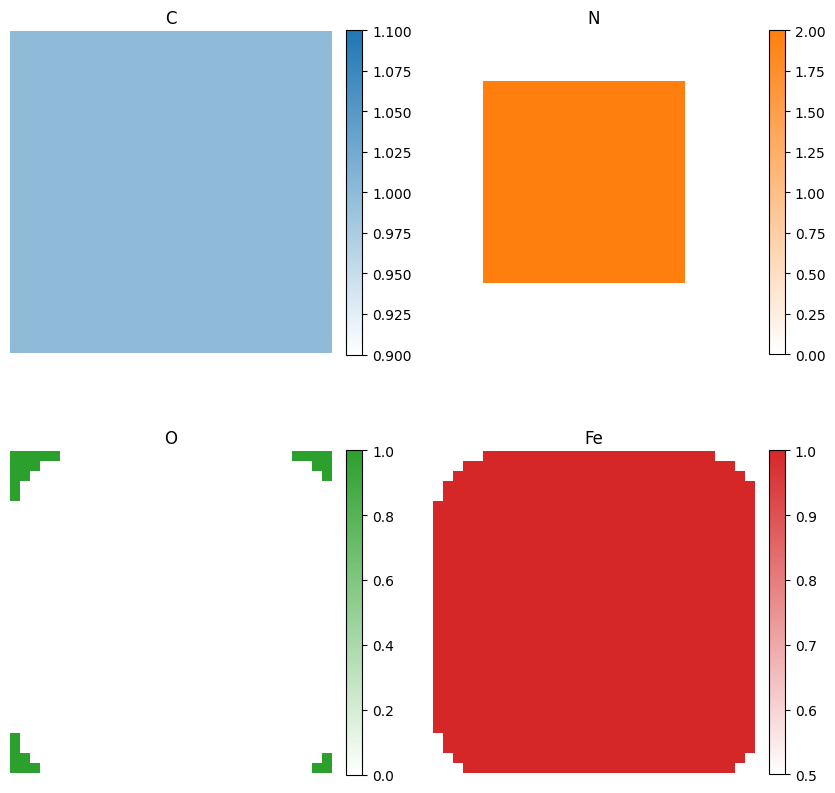

In [8]:
plot_ground_truth(maps=maps)

## Quantification Part
The previous part is the more irrelevant part which simulates the core-loss. In most of the cases, the data is available and needs to be processed. In this part, a typical workflow on getting the elemental abundance together with estimated errors is shown. Note that the ElementalQuantification class has such a workflow implemented in it but here we show how one can design their own workflow to optimize the data processing.

#### Aligning multispectra

In [9]:
fast_align = em.FastAlignZeroLoss(ll, other_spectra=[hl], cropping=True)

In [10]:
fast_align.perform_alignment()

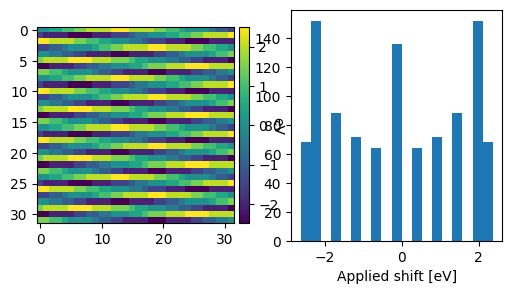

In [11]:
fig = fast_align.show_shift()

In [12]:
hl_al = fast_align.aligned_others[0] #coreloss which is used for quantification
ll_al = fast_align.aligned #lowloss which is used for quantification

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


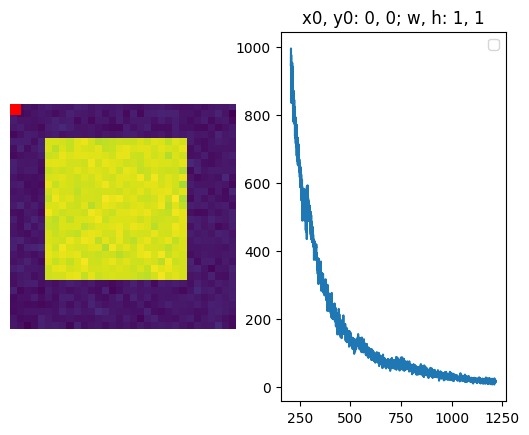

In [13]:
em.MultiSpectrumVisualizer([hl_al])

#### Define the model
The next step is to chose a proper model for the experimental data. In pyEELMODEL each model consist out of  components and each component has multiple parameters. For instance, a gaussian component has three parameters: ampltide, center and fwhm. For each parameter one can identify if it needs to be changeable or not. If it is not changeable then it will not be updated via the fitting procedure. The cross sections have multiple parameters but for elemental quantification only the amplitude is the unkown. More information on the model-based approach can be found here [[1]](https://doi.org/10.1016/j.ultramic.2006.05.006) \
The model for this example consists in this case out of three parts:

1. **The background**: Historically a powerlaw was used to model the background but in this example a linear background model is used[[2]](https://doi.org/10.1016/j.ultramic.2023.113830). This keeps the entire model linear which is advantages because no starting parameters are needed and no iterations need to be performed to find the global optimum.
   
2. **Atomic cross sections**: The generalized oscillator strengths from Zhang et al. [[3]](https://zenodo.org/records/7729585) are used. To properly calculate these cross sections, the acceleration voltage (E0), convergence angle (alpha) and collection angle (beta) are needed as input.
 
3. **The low loss**: Due to multiple scattering, the shape of cross sections will be modified and this can be taken into account if the low loss is acquired from the same area. Note that the background will not be convoluted in the model since this is hard to incorporate due to the artifacts arising from the boundaries [[1]](https://doi.org/10.1016/j.ultramic.2006.05.006).\
\
[1] Verbeeck J. et al; Model based quantification of EELS spectra; Ultramicroscopy; 2004; doi:[10.1016/j.ultramic.2006.05.006](https://doi.org/10.1016/j.ultramic.2006.05.006)\
[2] Van den Broek W. et al; Convexity constrains on linear background models for electron energy loss spectra; Ultramicroscopy; 2023; doi:[10.1016/j.ultramic.2023.113830](https://doi.org/10.1016/j.ultramic.2023.113830)\
[3] Zhang Z. et al; Generalised oscillator strength for core-shell excitation by fast electron based on Dirac solutions; Zenodo; 2023; doi:[10.5281/zenodo.7729585](https://zenodo.org/records/7729585)


##### Background component
The linear combination of fixed powerlaws where the powers are given by rlist:\
$$bg(E) = \sum_{i=0}^n A_i E^{-i}$$

In [14]:
from pyEELSMODEL.components.linear_background import LinearBG

In [15]:
n = 4
bg = LinearBG(specshape=hl_al.get_spectrumshape(), rlist=np.linspace(1,5,n))

##### Cross sections
The cross sections are calculated using the cross sections of [Zezhong Zhang](https://zenodo.org/records/7729585). In pyEELSMODEL, the hydrogenic K and L edges and the cross section from [Segger, Guzzinati and Kohl](https://zenodo.org/records/7645765) are also available. 

In [16]:
from pyEELSMODEL.components.CLedge.zezhong_coreloss_edgecombined import ZezhongCoreLossEdgeCombined
from pyEELSMODEL.components.CLedge.kohl_coreloss_edgecombined import KohlLossEdgeCombined

In [17]:
elements = ['C', 'N', 'O', 'Fe']
edges = ['K', 'K', 'K', 'L']
E0 = 300e3 
alpha = 1e-9
beta = 20e-3 

Showcase the difference between the two different GOS tables. 

In [18]:
# #can take a bit of time since the cross section is calculated from the tabulated GOS arrays
# fig, ax = plt.subplots(1,len(elements))
# for ii in range(len(elements)):
#     compz = ZezhongCoreLossEdgeCombined(hl_al.get_spectrumshape(), 1, E0, alpha,beta, elements[ii], edges[ii])
#     compz.calculate() #calculates the cross section with given parameters
    
#     compk = KohlLossEdgeCombined(hl_al.get_spectrumshape(), 1, E0, alpha,beta, elements[ii], edges[ii]) 
#     compk.calculate()

#     ax[ii].plot(compz.energy_axis, compz.data, label='Zhang')
#     ax[ii].plot(compk.energy_axis, compk.data, label='Kohl')
# ax[0].legend()



In [19]:
#can take a bit of time since the cross section is calculated from the tabulated GOS arrays
#can chose which cross section you use 
comp_elements = []
A = 1 #amplitude for cross section, since model is linear this value is not super important. For non-linear fitters the starting value could be important
for elem, edge in zip(elements, edges):
    comp = ZezhongCoreLossEdgeCombined(hl_al.get_spectrumshape(), 1, E0, alpha,beta, elem, edge)
    #comp = KohlLossEdgeCombined(hl_al.get_spectrumshape(), 1, E0, alpha,beta, elem, edge)
    comp_elements.append(comp)


hll
hll
hll
hll
hll
hll


##### Multiple scattering
The calculated components are convolved with the low loss if indicated. For instance, the background component will not be convolved with the lowloss 

In [20]:
from pyEELSMODEL.components.MScatter.mscatterfft import MscatterFFT

In [21]:
llcomp  = MscatterFFT(hl_al.get_spectrumshape(), ll_al)

##### Model
The model gets created by adding all the different components together into a list. It uses this information to calculate the resulting model and can be used as input for the fitter.

In [22]:
components = [bg]+comp_elements+[llcomp]
mod = em.Model(hl_al.get_spectrumshape(), components)

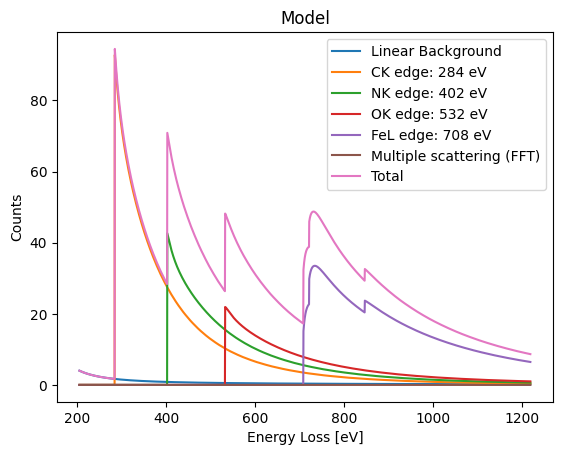

In [23]:
#shows the model with the given paramter values. 
mod.calculate()
mod.plot()

#### Finding optimal parameters for model
Since the model we defined is linear, we can use a weighted linear fitter. The weights are determined from the assumption that the noise is poisson distributed. 

In [24]:
#creates a fit object 
fit = em.LinearFitter(hl_al, mod, use_weights=True)

cannot use analytical gradients since a convolutor is inside model


In [25]:
fit.multi_fit()

1024it [00:01, 572.82it/s]


The fitted parameters can be accessed by following functions

(32, 32, 8)
8 parameters are optimized in the fitting procedure


Text(0.5, 1.0, 'NK edge: 402 eV')

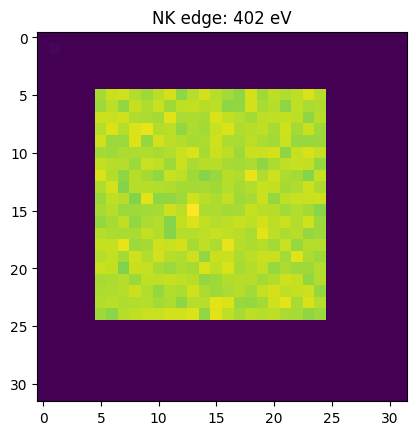

In [26]:
# the fitted parameters can be found in .coeff_matrix attribute.
print(fit.coeff_matrix.shape)
print(str(fit.coeff_matrix.shape[2])+' parameters are optimized in the fitting procedure')

#To know which parameter corresponds to which index in the coeff_matrix, following function can be used
N_index = fit.get_param_index(comp_elements[1].parameters[0]) #comp_elements[1].parameters[0]: amplitude of nitrogen edge
N_map = fit.coeff_matrix[:,:,N_index]

fig, ax = plt.subplots()
ax.imshow(N_map)
ax.set_title(comp_elements[1].name)

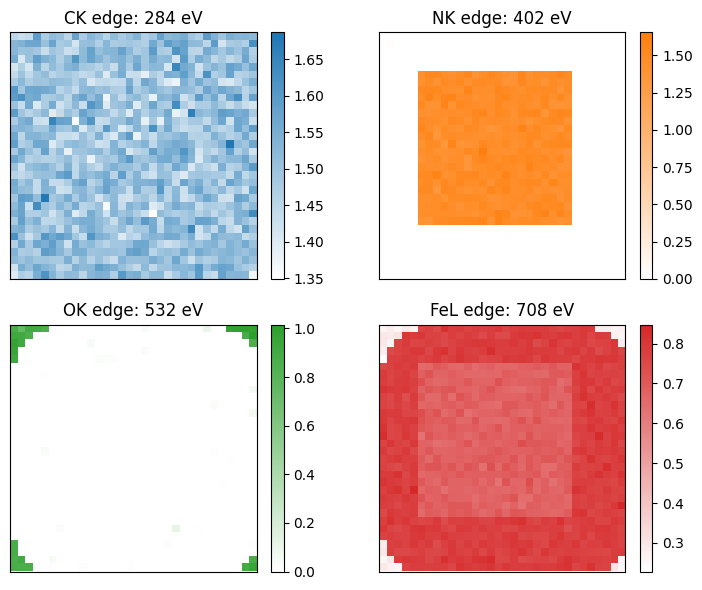

In [27]:
#function shows the elemental maps 
fig, maps, names = fit.show_map_result(comp_elements)

In [28]:
#calculates the fitted model, this can be used to validate visually the fitted results
multimodel = fit.model_to_multispectrum()

1024it [00:00, 10946.41it/s]


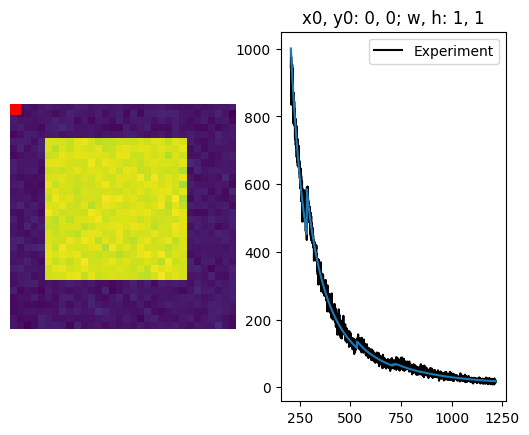

In [29]:
em.MultiSpectrumVisualizer([multimodel],experimental_spectra=hl_al)

In [30]:
#calculates the cramer rao lower bound for the given paramter at each probe position
crlb_Fe = fit.CRLB_map(comp_elements[3].parameters[0]) #comp_elements[3].parameters[0]: amplitude of iron edge

1024it [00:08, 126.08it/s]


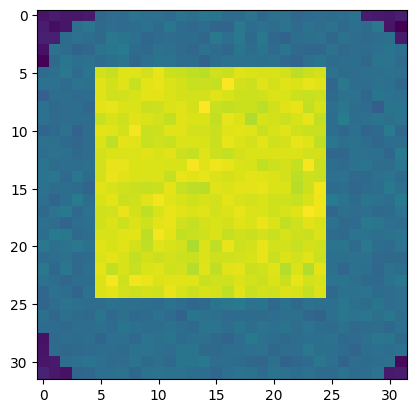

In [31]:
fig, ax = plt.subplots()
ax.imshow(crlb_Fe)

### ElementalQuantification class
The last part shows how the ElementalQuantification class is used as workflow to get the same result. 

hll
hll
hll
hll
hll
hll


cannot use analytical gradients since a convolutor is inside model
1024it [00:01, 679.90it/s]
1024it [00:00, 10799.43it/s]


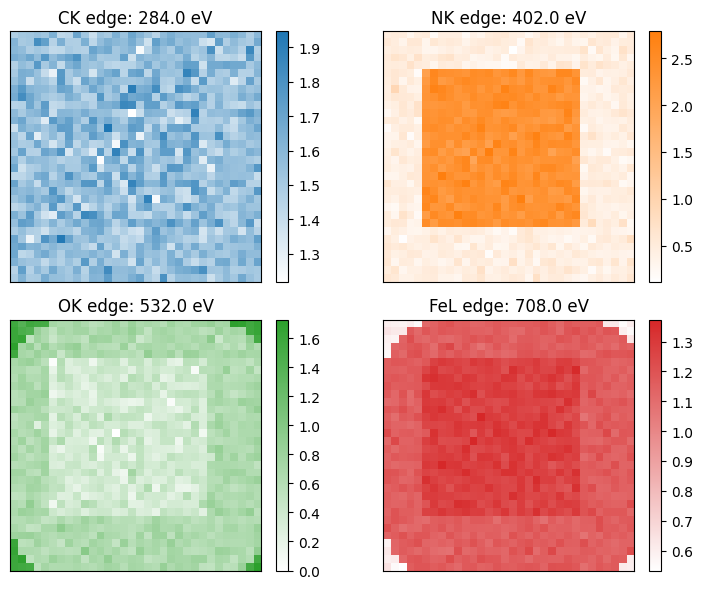

In [32]:
settings = (E0, alpha, beta)
quant = em.ElementalQuantification(hl, elements, edges, settings, ll=ll)
quant.background_model='linear'
quant.n_bgterms = 4
quant.linear_fitter_method = 'ols'
quant.do_procedure()

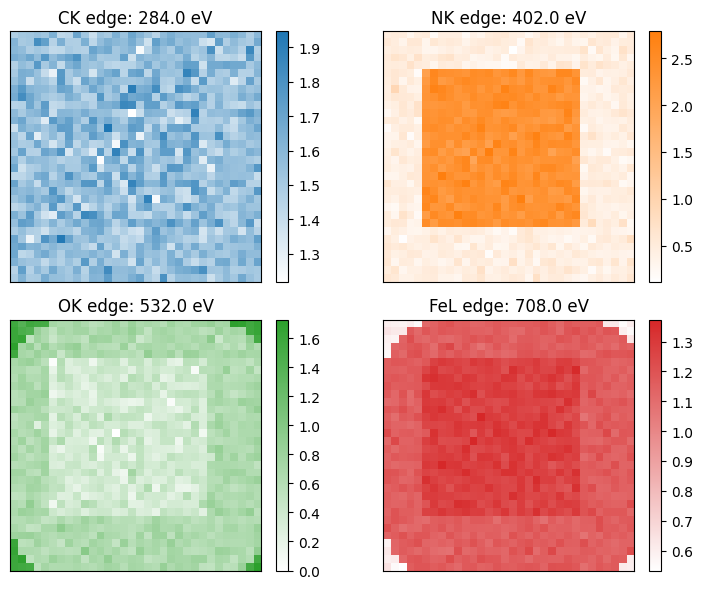

In [33]:
quant.show_elements_maps()

In [34]:
%matplotlib qt
multimodel = quant.get_multimodels()
labels = ['background']
# labels = ['background']
for elem, edge in zip(quant.elements, quant.edges):
    labels.append(elem + ' ' + edge)
em.MultiSpectrumVisualizer(multimodel, experimental_spectra=quant.spectrum, labels=labels)

1024it [00:00, 6625.91it/s]
1024it [00:00, 9611.44it/s]
1024it [00:00, 10462.77it/s]
1024it [00:00, 8546.08it/s]
1024it [00:00, 8201.56it/s]


In [40]:
em.MultiSpectrumVisualizer(multimodel, experimental_spectra=quant.spectrum, labels=labels)

Cannot make square larger
Cannot make square larger


In [36]:
em.MultiSpectrumVisualizer(multimodel, labels=labels)

In [37]:
multimodel[1].plot()

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
x = np.linspace(0, 10, 200)
y1 = np.sin(x)
y2 = np.sin(x) + 1
y3 = np.sin(x) + 2

# Plot the curves
plt.plot(x, y1, label='Curve 1')
plt.plot(x, y2, label='Curve 2')
plt.plot(x, y3, label='Curve 3')

# Fill the areas between the curves
plt.fill_between(x, y1, y2, where=(y2 > y1), interpolate=True, color='lightblue', alpha=0.5)
plt.fill_between(x, y2, y3, where=(y3 > y2), interpolate=True, color='lightgreen', alpha=0.5)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Filled Areas Between Curves')
plt.legend()

# Show the plot
plt.show()


In [39]:
quant.visualize_model()

1024it [00:00, 7802.75it/s]
1024it [00:00, 7674.68it/s]
1024it [00:00, 9442.66it/s]
1024it [00:00, 8458.07it/s]
1024it [00:00, 6093.50it/s]
